In [2]:
import os
import pandas as pd
import collections
import compress_pickle
import copy
import fnmatch
import itertools
import libsbml
import numpy as np
import time
import matplotlib.pyplot as plt
import requests
import csv
from io import StringIO
from dataclasses import dataclass
import re

# Import my local AMAS package
import sys
sys.path.insert(0, '/Users/luna/Desktop/CRBM/AMAS_proj/AMAS-v2')
from AMAS import recommender
from AMAS import constants as cn 
from AMAS import tools

In [3]:
# Directory
biomd_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioModels'
bigg_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BiggModels'
output_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Results/'

## Functions

In [60]:
@dataclass
class Recommendation:
    id: str  # ID from specs2evaluate
    name: str  # Species name ]
    candidates: list  # List of 'acc' values (accessions)
    candidate_names: list  # List of names of the predicted candidates

def getSpeciesDisplayName(model_file):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(model_file)
    model = document.getModel()
    names = {val.getId():val.name for val in model.getListOfSpecies()}
    return names

def clean_query(query):
    # Replace all non-alphanumeric characters with a space
    query = re.sub(r'[^a-zA-Z0-9]', ' ', query)
    # Replace multiple spaces with a single space
    query = re.sub(r'\s+', ' ', query).strip()
    return query

def clean_output_name(name):
    # Replace HTML entities
    name = re.sub(r'&#8722;', '-', name)  # Replace minus sign
    name = re.sub(r'&#[0-9]+;', '', name)  # Remove any other HTML entities
    return name.strip()


def getSpeciesRecommendationsAPI(specs2evaluate, display_names, domain="chebi", query_size=10, return_size=10):
    """
    Query the ChEBI API to get ranked recommendations.

    Parameters:
    - specs2evaluate (list): List of species IDs to evaluate.
    - display_names (dict): Mapping of species IDs to display names.
    - domain (str): Domain for the API (default: 'chebi').
    - query_size (int): Number of candidates to retrieve from the API.
    - return_size (int): Number of top candidates to return after ranking.

    Returns:
    - list: List of Recommendation objects with top-ranked candidates and names.
    """
    url = 'https://www.ebi.ac.uk/ebisearch/ws/rest/' + domain
    headers = {
        'Accept': 'text/csv',
    }
    recommendations = []

    for spec_id in specs2evaluate:
        # Derive species name from display_names or use spec_id as fallback
        species_name = display_names[spec_id] if spec_id in display_names and display_names[spec_id] else spec_id
        cleaned_species_name = clean_query(species_name)
        # Skip empty names after cleaning
        if not cleaned_species_name.strip():
            recommendations.append(Recommendation(name=species_name, candidates=[], candidate_names=[]))
            continue

        params = {
            'query': cleaned_species_name,
            'fields': 'acc,name',
            'size': query_size
        }

        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            csv_data = response.text
            # Parse CSV data
            csv_reader = csv.reader(StringIO(csv_data))
            results = list(csv_reader)
            if len(results) > 1:
                # Extract candidates as (accession, name) tuples
                candidates = [
                    (item[0], clean_output_name(item[1])) for item in results[1:] if len(item) > 1
                ]
                if query_size != return_size:
                    # Rank candidates by name length
                    ranked_candidates = sorted(candidates, key=lambda x: len(x[1]))
                    # Keep only the top `return_size` candidates
                    top_candidates = ranked_candidates[:return_size]
                else:
                    top_candidates = candidates
                # Separate accessions and names
                acc_list = [item[0] for item in top_candidates]
                name_list = [item[1] for item in top_candidates]
                # Create the Recommendation object
                recommendation = Recommendation(
                    id=spec_id,
                    name=species_name,
                    candidates=acc_list,
                    candidate_names=name_list
                )
            else:
                recommendation = Recommendation(id=spec_id, name=species_name, candidates=[], candidate_names=[])
        else:
            print(f"Error for {species_name} (ID: {spec_id}): {response.status_code}, Response: {response.text}")
            recommendation = Recommendation(id=spec_id,name=species_name, candidates=[], candidate_names=[])
        recommendations.append(recommendation)
    return recommendations

def getSpeciesStatisticsAPI(recomsAPI, refs_formula, refs_chebi, model_mean=False):
    preds_chebi = {val.id: [k for k in val.candidates]
                   for val in recomsAPI}
    preds_formula = {k: [cn.REF_CHEBI2FORMULA[val] for val in preds_chebi[k]
                    if val in cn.REF_CHEBI2FORMULA.keys()]
                    for k in preds_chebi.keys()}
    recall_formula = tools.getRecall(ref=refs_formula, pred=preds_formula, mean=model_mean)
    precision_formula = tools.getPrecision(ref=refs_formula, pred=preds_formula, mean=model_mean)
    recall_chebi = tools.getRecall(ref=refs_chebi, pred=preds_chebi, mean=model_mean)
    precision_chebi = tools.getPrecision(ref=refs_chebi, pred=preds_chebi, mean=model_mean)
    return {'recall_formula': recall_formula, 'recall_chebi': recall_chebi, 'precision_formula': precision_formula, 'precision_chebi': precision_chebi}

def generate_species_accuracyAPI(
    model_dir, output_path, query_size = 10, return_size = 10, domain='chebi', num_models = 'all'):
    """
    Generate species accuracy statistics for a set of models.
    """
    model_files = [
        f for f in os.listdir(model_dir) if f.endswith('.xml')
    ]
    if num_models != 'all':
        model_files = model_files[:num_models]
    print(f"Running on {len(model_files)} models.")

    model_names = []
    species_id = []
    species_name = []
    len_names = []
    exist_annotation_chebi = []
    exist_annotation_name = []
    predictions = []
    predictions_names = []
    num_formulas = []
    recall_formula = []
    precision_formula = []
    recall_chebi = []
    precision_chebi = []
    is_correct_included = []
    processing_time = []

    for idx, model_file in enumerate(model_files):
        print(f"Processing model {idx + 1}/{len(model_files)}: {model_file}")
        one_fpath = os.path.join(model_dir, model_file)
        recom = recommender.Recommender(libsbml_fpath=one_fpath)
        specs2evaluate = list(recom.species.exist_annotation_formula.keys())
        if not specs2evaluate:
            continue
        display_names = getSpeciesDisplayName(one_fpath)
        display_name_to_id = {v: k for k, v in display_names.items()}
        time_start = time.time()
        # Query API
        recomsAPI = getSpeciesRecommendationsAPI(specs2evaluate, display_names, query_size=query_size, return_size=return_size, domain=domain)
        time_end = time.time()
        if not recomsAPI:
            continue
        refs_formula = {val: recom.species.exist_annotation_formula[val]
                for val in recom.species.exist_annotation_formula.keys()
                if recom.species.exist_annotation_formula[val]}
        refs_chebi = recom.species.exist_annotation
        stats = getSpeciesStatisticsAPI(recomsAPI, refs_formula, refs_chebi, model_mean=False)
        recalls_formula = stats['recall_formula']
        precisions_formula = stats['precision_formula']
        recalls_chebi = stats['recall_chebi']
        precisions_chebi = stats['precision_chebi']
        for one_recom in recomsAPI:
            model_names.append(model_file)
            one_id = one_recom.id
            species_id.append(one_id)
            one_spec = one_recom.name
            species_name.append(one_spec)
            len_names.append(len(species_name[-1]))
            predictions.append(one_recom.candidates)
            predictions_names.append(one_recom.candidate_names)

            # Add the existing annotation
            try:
                exist_annotation_chebi.append(refs_chebi[one_id])
            except KeyError:
                exist_annotation_chebi.append('NA')

            # Add labels for existing annotation
            try:
                labels = [cn.REF_CHEBI2LABEL.get(item, 'NA') for item in refs_chebi[one_id]]
                concatenated_labels = ', '.join(labels)
            except Exception as e:
                print(f"Error generating annotation labels for {one_id}: {e}")
                concatenated_labels = 'NA'
            exist_annotation_name.append(concatenated_labels)

            recall_formula.append(recalls_formula[one_id])
            precision_formula.append(precisions_formula[one_id])
            recall_chebi.append(recalls_chebi[one_id])
            precision_chebi.append(precisions_chebi[one_id])
            if recalls_formula[one_id] > 0 or recalls_chebi[one_id] > 0 :
                is_correct_included.append(1)
            else:
                is_correct_included.append(0)

            processing_time.append(time_end - time_start)
        # if idx % 100 == 0:
            # spec_df = pd.DataFrame({'model': model_names,
            #                         'species_id': species_id,
            #                         'species_name': species_name,
            #                         'name_length': len_names,
            #                         'exist_annotation_chebi': exist_annotation_chebi,
            #                         'exist_annotation_name': exist_annotation_name,
            #                         'predictions': predictions,
            #                         'predictions_names':predictions_names,
            #                         'recall_formula': recall_formula,
            #                         'precision_formula': precision_formula,
            #                         'recall_chebi': recall_chebi,
            #                         'precision_chebi': precision_chebi,                                    
            #                         'accuracy': is_correct_included,
            #                         'processing_time': processing_time})
            # spec_df.to_csv(f'temp_species_accuracy_API_{idx+1}.csv', index=False)

    spec_df = pd.DataFrame({'model': model_names,
                            'species_id': species_id,
                            'species_name': species_name,
                            'name_length': len_names,
                            'exist_annotation_chebi': exist_annotation_chebi,
                            'exist_annotation_name': exist_annotation_name,
                            'predictions': predictions,
                            'predictions_names':predictions_names,
                            'recall_formula': recall_formula,
                            'precision_formula': precision_formula,
                            'recall_chebi': recall_chebi,
                            'precision_chebi': precision_chebi,  
                            'accuracy': is_correct_included,
                            'processing_time': processing_time})
    # Save the DataFrame to a CSV file
    spec_df.to_csv(output_path, index=False)
    print(f"Saved to file: {output_path}")

def print_results(output_csv):
    df = pd.read_csv(output_dir+output_csv)
    df.head()
    print("Number of models assessed: %d" % df['model'].nunique())
    print("Number of models with predictions: %d" % df[df['predictions'] != '[]']['model'].nunique())
    print("Average recall (per model) using formula: %.02f" % df.groupby('model')['recall_formula'].mean().mean())
    print("Average precision (per model) using formula: %.02f" % df.groupby('model')['precision_formula'].mean().mean())
    print("Average recall (per model) using ChEBI ID: %.02f" % df.groupby('model')['recall_chebi'].mean().mean())
    print("Average precision (per model) using ChEBI ID: %.02f" % df.groupby('model')['precision_chebi'].mean().mean())
    
    print("Average accuracy (per model): %.02f" % df.groupby('model')['accuracy'].mean().mean())
    mean_processing_time = df.groupby('model')['processing_time'].first().mean()
    print("Ave. processing time (per model): %.02f" % mean_processing_time)
    num_elements = df.groupby('model').size().mean()
    mean_processing_time_per_element = mean_processing_time / num_elements
    print("Ave. processing time (per element, per model): %.02f" % mean_processing_time_per_element)
    # Average number of predictions per species
    def safe_eval_with_eval(x):
        try:
            return eval(x) if isinstance(x, str) else []
        except Exception as e:
            print(f"Failed to parse: {x} with error: {e}")
            return []
    df['parsed_predictions'] = df['predictions'].apply(safe_eval_with_eval)
    df['num_predictions'] = df['parsed_predictions'].apply(len)
    average_predictions = df['num_predictions'].mean()
    print(f"Average number of predictions per row: {average_predictions}")

def print_results_nosymbol(output_csv):
    df = pd.read_csv(output_dir+output_csv)
    df.head()
    print("Number of models assessed: %d" % df['model'].nunique())
    print("Number of models with predictions: %d" % df[df['predictions'] != '[]']['model'].nunique())
    print("Average recall (per model): %.02f" % df.groupby('model')['recall_formula'].mean().mean())
    print("Average precision (per model): %.02f" % df.groupby('model')['precision_formula'].mean().mean())
    print("Average recall (per model) for ChEBI: %.02f" % df.groupby('model')['recall_chebi'].mean().mean())
    print("Average precision (per model) for ChEBI: %.02f" % df.groupby('model')['precision_chebi'].mean().mean())
    print("Average accuracy (per model): %.02f" % df.groupby('model')['accuracy'].mean().mean())
    mean_processing_time = df.groupby('model')['processing_time'].first().mean()
    print("Ave. processing time (per model): %.02f" % mean_processing_time)
    num_elements = df.groupby('model').size().mean()
    mean_processing_time_per_element = mean_processing_time / num_elements
    print("Ave. processing time (per element, per model): %.02f" % mean_processing_time_per_element)
    # Average number of predictions per species
    def safe_eval_with_eval(x):
        try:
            return eval(x) if isinstance(x, str) else []
        except Exception as e:
            print(f"Failed to parse: {x} with error: {e}")
            return []
    df['parsed_predictions'] = df['predictions'].apply(safe_eval_with_eval)
    df['num_predictions'] = df['parsed_predictions'].apply(len)
    average_predictions = df['num_predictions'].mean()
    print(f"Average number of predictions per row: {average_predictions}")

In [350]:
one_fpath = "/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioModels/BIOMD0000000191.xml"
recom = recommender.Recommender(one_fpath)
specs2evaluate = list(recom.species.exist_annotation_formula.keys())
display_names = getSpeciesDisplayName(one_fpath)
display_name_to_id = {v: k for k, v in display_names.items()}
recomsAPI = getSpeciesRecommendationsAPI(specs2evaluate, display_names, query_size=10, return_size=10, domain='chebi')
recomsAPI


[Recommendation(id='ARGex', name='Arginine ex', candidates=[], candidate_names=[]),
 Recommendation(id='ORN', name='Ornithine', candidates=['CHEBI:18257', 'CHEBI:15729', 'CHEBI:16176', 'CHEBI:21368', 'CHEBI:25718', 'CHEBI:44673', 'CHEBI:84714', 'CHEBI:143003', 'CHEBI:16543', 'CHEBI:143160'], candidate_names=['ornithine', 'L-ornithine', 'D-ornithine', 'L-ornithine derivative', 'ornithine derivative', 'N5-acetyl-L-ornithine', 'D-ornithine derivative', 'EC 2.1.3.3 (ornithine carbamoyltransferase) inhibitor', 'N2-acetyl-L-ornithine', 'N2-(4-aminobutanoyl)-L-ornithine(1+)']),
 Recommendation(id='ARGin', name='Arginine in', candidates=['CHEBI:138933', 'CHEBI:40521', 'CHEBI:90086', 'CHEBI:73972', 'CHEBI:143208', 'CHEBI:114953', 'CHEBI:62167', 'CHEBI:4450', 'CHEBI:59728', 'CHEBI:144928'], candidate_names=['N-nitroso-L-arginine', 'N-acetyl-L-arginine', 'N-benzoyl-L-arginine', '(3S)-3-hydroxy-L-arginine', 'N-hydroxy-N-hydroxy-N-methyl-L-arginine zwitterion', '(2S)-2-ammonio-5-{[iminio(methylamin

## Model statistics and evaluation results

### BioModels species statistics


In [16]:
output_csv = 'biomd_species_accuracy_API_query10_return10.csv'
generate_species_accuracyAPI(biomd_model_dir, output_dir+output_csv, query_size=10)

Running on 1063 models.
Processing model 1/1063: BIOMD0000000634.xml
Processing model 2/1063: BIOMD0000000152.xml
Processing model 3/1063: BIOMD0000000146.xml
Processing model 4/1063: BIOMD0000000620.xml
Processing model 5/1063: BIOMD0000000608.xml
Processing model 6/1063: BIOMD0000000191.xml
Processing model 7/1063: BIOMD0000000185.xml
Processing model 8/1063: BIOMD0000000813.xml
Processing model 9/1063: BIOMD0000000807.xml
Processing model 10/1063: BIOMD0000000350.xml
Processing model 11/1063: BIOMD0000000436.xml
Processing model 12/1063: BIOMD0000000422.xml
Processing model 13/1063: BIOMD0000000344.xml
Processing model 14/1063: BIOMD0000001072.xml
Processing model 15/1063: BIOMD0000000378.xml
Processing model 16/1063: BIOMD0000000393.xml
Processing model 17/1063: BIOMD0000000387.xml
Processing model 18/1063: BIOMD0000000224.xml
Processing model 19/1063: BIOMD0000000542.xml
Processing model 20/1063: BIOMD0000000556.xml
Processing model 21/1063: BIOMD0000000230.xml
Processing model 22

In [39]:
print("\n\n<BioModels Species with query_size 10 with symbols>")
print_results('biomd_species_accuracy_API_query10_withSymbols.csv')



<BioModels Species with query_size 10 with symbols>
Number of models assessed: 299
Number of models with predictions: 255
Average recall (per model) using formula: 0.38
Average precision (per model) using formula: 0.17
Average recall (per model) using ChEBI ID: 0.23
Average precision (per model) using ChEBI ID: 0.08
Average accuracy (per model): 0.38
Ave. processing time (per model): 22.09
Ave. processing time (per element, per model): 0.70
Average number of predictions per row: 4.618580617947907


In [38]:
print("\n\n<BioModels Species with query_size 10>")
print_results('biomd_species_accuracy_API_query10_return10.csv')



<BioModels Species with query_size 10>
Number of models assessed: 314
Number of models with predictions: 285
Average recall (per model) using formula: 0.41
Average precision (per model) using formula: 0.18
Average recall (per model) using ChEBI ID: 0.24
Average precision (per model) using ChEBI ID: 0.08
Average accuracy (per model): 0.41
Ave. processing time (per model): 24.67
Ave. processing time (per element, per model): 0.80
Average number of predictions per row: 4.8268353380340105


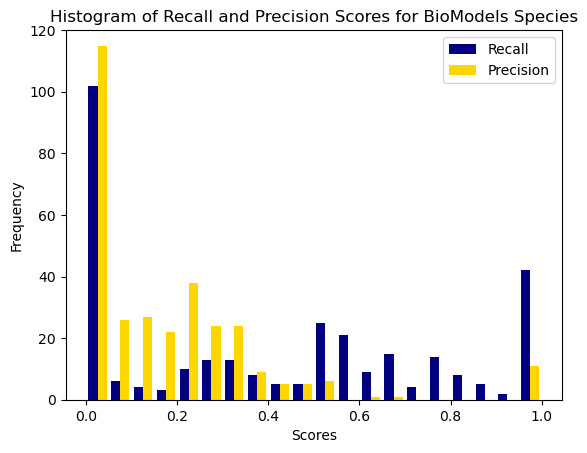

In [20]:
# BioModels species
biomd_species_accuracy_API = pd.read_csv(output_dir+'biomd_species_accuracy_API_query10_return10.csv')
df1 = biomd_species_accuracy_API.groupby('model')[['recall_formula', 'precision_formula']].mean()
ax = plt.gca()
ax.hist(x=[df1['recall_formula'], df1['precision_formula']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'])
ax.set_ylim(0, 120)
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for BioModels Species')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_spec_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)

In [21]:
api_df = pd.read_csv(output_dir+'biomd_species_accuracy_API_query10_return10.csv')
amas_df = pd.read_csv(output_dir+'biomd_species_accuracy_AMAS.csv')
merged_df = pd.merge(api_df, amas_df, on=['model', 'species_name'], suffixes=('_api', '_amas'))

# Filter rows where the recall from the API is greater than the recall from AMAS
lower_recall_df = merged_df[merged_df['recall_formula_api'] < merged_df['recall_formula_amas']]
lower_recall_df.to_csv(output_dir+'lower_recall_api_vs_amas.csv', index=False)

# higher recall
higher_recall_df = merged_df[merged_df['recall_formula_api'] > merged_df['recall_formula_amas']]
higher_recall_df.to_csv(output_dir+'higher_recall_api_vs_amas.csv', index=False)

## Test on the API parameters

Retreive 50 results and ranking using name length, return only the top 10 with shortest names.

In [366]:
output_csv = 'biomd_species_accuracy_API_query20_return10.csv'
generate_species_accuracyAPI(biomd_model_dir, output_dir+output_csv, query_size=20,return_size=10)

Running on 1063 models.
Processing model 1/1063: BIOMD0000000634.xml
Processing model 2/1063: BIOMD0000000152.xml
Processing model 3/1063: BIOMD0000000146.xml
Processing model 4/1063: BIOMD0000000620.xml
Processing model 5/1063: BIOMD0000000608.xml
Processing model 6/1063: BIOMD0000000191.xml
Processing model 7/1063: BIOMD0000000185.xml
Processing model 8/1063: BIOMD0000000813.xml
Processing model 9/1063: BIOMD0000000807.xml
Processing model 10/1063: BIOMD0000000350.xml
Processing model 11/1063: BIOMD0000000436.xml
Processing model 12/1063: BIOMD0000000422.xml
Processing model 13/1063: BIOMD0000000344.xml
Processing model 14/1063: BIOMD0000001072.xml
Processing model 15/1063: BIOMD0000000378.xml
Processing model 16/1063: BIOMD0000000393.xml
Processing model 17/1063: BIOMD0000000387.xml
Processing model 18/1063: BIOMD0000000224.xml
Processing model 19/1063: BIOMD0000000542.xml
Processing model 20/1063: BIOMD0000000556.xml
Processing model 21/1063: BIOMD0000000230.xml
Processing model 22

In [70]:
print("\n\n<BioModels Species with query_size 3, return_size 3>")
print_results_nosymbol('biomd_species_accuracy_API_query3_return3.csv')



<BioModels Species with query_size 3, return_size 3>
Number of models assessed: 314
Number of models with predictions: 285
Average recall (per model): 0.35
Average precision (per model): 0.26
Average recall (per model) for ChEBI: 0.17
Average precision (per model) for ChEBI: 0.09
Average accuracy (per model): 0.35
Ave. processing time (per model): 34.05
Ave. processing time (per element, per model): 1.11
Average number of predictions per row: 1.6352136043135628


## Bigg models species

In [77]:
output_csv = 'bigg_species_accuracy_API_query5_return5_first10.csv'
generate_species_accuracyAPI(bigg_model_dir, output_dir+output_csv, query_size = 5, return_size = 5, num_models = 10)

Running on 10 models.
Processing model 1/10: iCHOv1.xml
Processing model 2/10: iYL1228.xml
Error for (S)-2-[5-Amino-1-(5-phospho-D-ribosyl)imidazole-4-carboxamido]succinate (ID: M_25aics_c): 500, Response: "Internal server error. If the problem persists please contact us at http://www.ebi.ac.uk/support/ebi-search."

Processing model 3/10: iIS312.xml
Processing model 4/10: iSDY_1059.xml
Processing model 5/10: iEC1356_Bl21DE3.xml
Processing model 6/10: iECP_1309.xml
Processing model 7/10: iJN746.xml
Processing model 8/10: iJR904.xml
Processing model 9/10: iJB785.xml
Processing model 10/10: iY75_1357.xml
Saved to file: /Users/luna/Desktop/CRBM/AMAS_proj/Results/bigg_species_accuracy_API_query5_return5_first10.csv


In [78]:
print("\n\n<Bigg Species with query_size 5, return_size 5>")
print_results_nosymbol('bigg_species_accuracy_API_query5_return5_first10.csv')



<Bigg Species with query_size 5, return_size 5>
Number of models assessed: 10
Number of models with predictions: 10
Average recall (per model): 0.74
Average precision (per model): 0.42
Average recall (per model) for ChEBI: 0.22
Average precision (per model) for ChEBI: 0.31
Average accuracy (per model): 0.75
Ave. processing time (per model): 860.04
Ave. processing time (per element, per model): 0.71
Average number of predictions per row: 3.8824407229315203


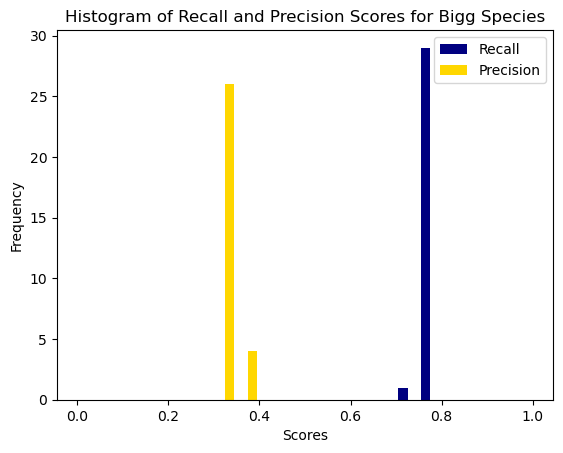

In [40]:
# Bigg species
bigg_species_accuracy = pd.read_csv(output_dir + 'bigg_species_accuracy_API_10_withSymbols.csv')
df1 = bigg_species_accuracy.groupby('model')[['recall', 'precision']].mean()
ax = plt.gca()
ax.hist(x=[df1['recall'], df1['precision']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'], range=(0, 1))
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for Bigg Species')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_spec_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)

In [ ]:
output_csv = 'bigg_species_accuracy_API_query5_return5.csv'
generate_species_accuracyAPI(bigg_model_dir, output_dir+output_csv, query_size = 5, return_size = 5,num_models = 30)

In [ ]:
print("\n\n<Bigg Species with query_size 5, return_size 5>")
print_results('bigg_species_accuracy_API_query5_return5.csv')

## Visualizations

<Figure size 1000x600 with 0 Axes>

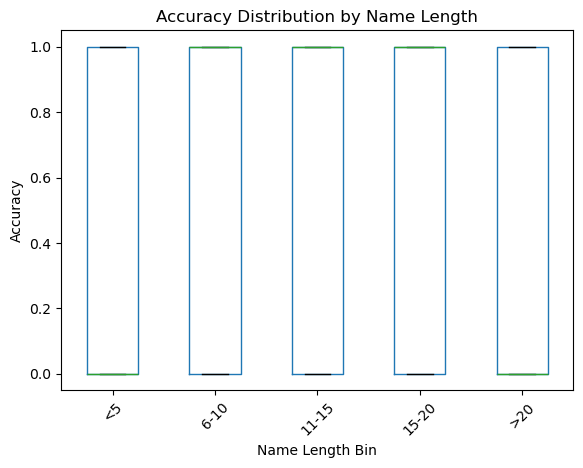

In [27]:
df = pd.read_csv(output_dir+"biomd_species_accuracy_API_query10_return10.csv")

bins = [0, 5, 10, 15, 20, float('inf')]
labels = ['<5', '6-10', '11-15', '15-20', '>20']
df['name_length_bin'] = pd.cut(df['name_length'], bins=bins, labels=labels)

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x='name_length_bin', y='accuracy', data=df)
plt.title('Accuracy Distribution by Name Length')
plt.xlabel('Name Length Bin')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()
